# Extractor of Star Formation History (SFH) snapshots
With this code, I extract a series of 10 snapshots at different times along the SFH plot, to be processed, starting off with the one that I post processed so far, since the very beginning.

# Importing the Simulation, the units, selecting snapshots & HISTORY DUMP

In [1]:
# Importing the paths of the first snapshot of the simulation
# Importing the snapshot class and the units
# Printing the SFH dump and the 10 slices

import sys
sys.path.insert(0, '/export/home/extragal/lucia.armillotta/pyathena')
import pyathena as pa

from astropy.io import fits
from astropy import units
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
import h5py
from matplotlib.colors import LogNorm
from scipy.ndimage import shift
from pyathena.util.expand_domain import expand_xy
from scipy.integrate import quad
import matplotlib.transforms as transforms
from matplotlib.transforms import Bbox
from collections import Counter
import matplotlib.patches as patches
from scipy.interpolate import interp1d

tot_height_cells = 384
max_height = 768 + tot_height_cells // 2
min_height = 768 - tot_height_cells // 2

basedir = '/export/home/extragal/lucia.armillotta/TIGRESS/R8'
output_dir_Halpha = '/export/home/extragal/francesco.chititegli/TIGRESS_1/Halfa/'
output_dir_HI = '/export/home/extragal/francesco.chititegli/TIGRESS_1/H21maps/'
output_dir_IR = '/export/home/extragal/francesco.chititegli/TIGRESS_1/IRmaps/'
output_dir_exp = '/export/home/extragal/francesco.chititegli/TIGRESS_1/SPExpanded/'
output_dir_exp_history = '/export/home/extragal/francesco.chititegli/TIGRESS_1/History_SPExpanded/'
#tigress_dir = '/export/home/extragal/francesco.chititegli/TIGRESS_1/'
snapshot_number = 0

s = pa.LoadSim(basedir, verbose=False)
ds = s.load_vtk(num=s.nums[snapshot_number])
u = s.u

[FindFiles-WARNING] Vtk file size is not unique.
[FindFiles-WARNING] vtk num: 0, size [MB]: 8834
[FindFiles-WARNING] vtk num: 1, size [MB]: 8834
[FindFiles-WARNING] vtk num: 2, size [MB]: 8834
[FindFiles-WARNING] vtk num: 3, size [MB]: 8834
[FindFiles-WARNING] vtk num: 4, size [MB]: 8834
[FindFiles-WARNING] vtk num: 5, size [MB]: 8834
[FindFiles-WARNING] vtk num: 6, size [MB]: 8834
[FindFiles-WARNING] vtk num: 7, size [MB]: 8834
[FindFiles-WARNING] vtk num: 8, size [MB]: 8834
[FindFiles-WARNING] rst files in out_fmt but not found.


xi_CR0 not found. Use 2e-16.


In [2]:

h = pa.read_hst(s.files['hst'])
print('Columns: ' + str(h.columns))

time_cf = (u.time).to(units.Gyr).value
mass_cf = (s.u.mass).to(units.M_sun).value
density_cf = (s.u.density).to(units.M_sun / units.pc**3).value
number_density_cf = (units.cm**-3).to(units.pc**-3)
solar_metallicity = 0.0134
dust_to_gas_ratio = 0.01
h_alpha_wave = 0.65628 # (micron)
h_alpha_energy = 3.03e-12 # (erg)
H_mass = 8.41e-58 # (Msun)
H_mass_grams = 1.67e-24 # (grams)

print(s.basedir)
print(s.basename)
print(s.problem_id)
Nx = ds.domain['Nx']

# Printing the domain borders and cuboid cells grid

time_snapshot = ds.domain["time"]
Lxyz = ds.domain["Lx"]
qOmL = s.par["problem"]["qshear"]*s.par["problem"]["Omega"]*Lxyz[0]
qOmLt = qOmL * time_snapshot
dx = ds.domain['dx']
volume = dx[0] * dx[1] * dx[2]
s.domain

Columns: Index(['time', 'dt', 'mass', 'totalE', 'x1Mom', 'x2Mom', 'x3Mom', 'x1KE',
       'x2KE', 'x3KE', 'x1ME', 'x2ME', 'x3ME', 'gravPE', 'scalar0', 'scalar1',
       'scalar2', 'scalar3', 'scalar4', 'dmasssink', 'dM1sink', 'dM2sink',
       'dM3sink', 'dEsink', 'heat_ratio', 'heat_ratio_mid',
       'heat_ratio_mid_2p', 'ftau', 'x2dke', 'nmid', 'Pth_mid', 'Pturb_mid',
       'Vmid_2p', 'nmid_2p', 'Pth_mid_2p', 'Pturb_mid_2p', 'sfr10', 'sfr40',
       'sfr100', 'msp', 'metal_sp', 'total_ecool', 'total_eheat', 'total_enet',
       'V_Erad_PH', 'Lmasked_HI_PH', 'Lmasked_H2_PH', 'Lmasked_dust_PH',
       'Lmasked_dust_LW', 'Lmasked_dust_PE', 'phot_rate_HI', 'phot_rate_H2',
       'rec_rate_rad_HII', 'rec_rate_gr_HII', 'xi_CR0', 'Ltot0', 'Ltot1',
       'Ltot2', 'Ltot3', 'Lesc0', 'Lesc1', 'Lesc2', 'Lesc3', 'Ldust0',
       'Ldust1', 'Ldust2', 'Ldust3', 'Lxymax0', 'Lxymax1', 'Lxymax2',
       'Lxymax3', 'Lpp0', 'Lpp1', 'Lpp2', 'Lpp3', 'Leps0', 'Leps1', 'Leps2',
       'Leps3'],
      dtyp

{'all_grid_equal': True,
 'ngrid': 768,
 'le': array([ -512.,  -512., -3072.], dtype=float32),
 're': array([ 512.,  512., 3072.], dtype=float32),
 'dx': array([4., 4., 4.], dtype=float32),
 'Lx': array([1024., 1024., 6144.], dtype=float32),
 'center': array([0., 0., 0.], dtype=float32),
 'Nx': array([ 256,  256, 1536]),
 'ndim': 3,
 'time': 200.0007}

Number of peaks in SFH: 17
Number of cavities in SFH: 15
Times from 260 Myr to 350 Myr
Indexes from 6 to 15


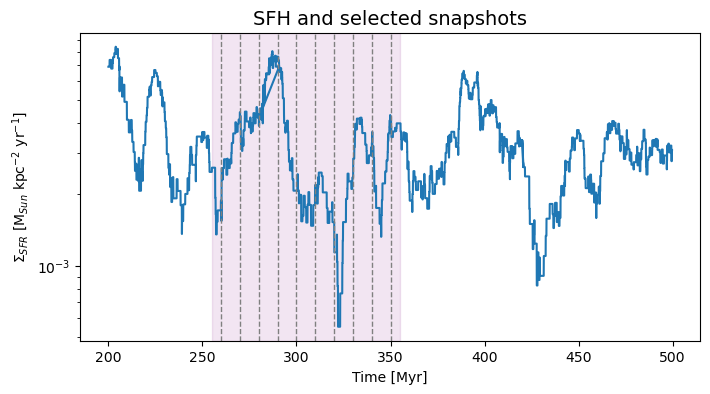

In [3]:
timesteps = np.array(h['time'])
SFH10 = np.array(h['sfr10'])

def peaks_cav_finder(h, y_col='sfr10', time_col='time', prominence=1e-3):
    y = h[y_col].values
    x = h[time_col].values

    y_smooth = gaussian_filter1d(y, sigma=2)
    
    peaks_idx, _ = find_peaks(y_smooth, prominence=prominence)
    cav_idx, _ = find_peaks(-y_smooth, prominence=prominence)

    peaks = list(zip(x[peaks_idx], y[peaks_idx]))
    cav = list(zip(x[cav_idx], y[cav_idx]))

    return np.array(peaks), np.array(cav), np.array(y_smooth)

peaks_SFH, cavities_SFH, SFH10smooth = peaks_cav_finder(h)
print('Number of peaks in SFH: ' + str(len(peaks_SFH)))
print('Number of cavities in SFH: ' + str(len(cavities_SFH)))

fig = plt.figure(figsize=(8, 4), dpi=100)

beginning = 6
snapshot_indexes_to_export = list(range(beginning, beginning + 10))
snapshots_times_to_export = s.nums[beginning:beginning+10]
plt.plot(timesteps, SFH10)
for x in snapshots_times_to_export:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=1)
print('Times from ' + str(s.nums[beginning]) + ' Myr to ' + str(s.nums[beginning+9]) + ' Myr')
print('Indexes from ' + str(snapshot_indexes_to_export[0]) + ' to ' + str(snapshot_indexes_to_export[len(snapshot_indexes_to_export)-1]))
plt.axvspan(260-5, 350+5, color='purple', alpha=0.1)
plt.xlabel("Time [Myr]")
plt.ylabel(r"$\Sigma$$_{SFR}$ [M$_{Sun}$ kpc$^{-2}$ yr$^{-1}$]")
plt.title("SFH and selected snapshots", fontsize=14)
plt.yscale("log")

plt.show()

# Extracting, expanding and plotting the snapshots

In [4]:
# Cell borders are always the same, regardless of the snapshot

xmin = ds.domain['le'][0] + dx[0] * np.arange(Nx[0])
ymin = ds.domain['le'][1] + dx[1] * np.arange(Nx[1])
zmin = ds.domain['le'][2] + dx[2] * np.arange(Nx[2])
xmax = xmin + dx[0]
ymax = ymin + dx[1]
zmax = zmin + dx[2]

# Expanding the cells borders
Nx_exp = np.array([3 * Nx[0], 3 * Nx[1], Nx[2]])
origin = ds.domain['le'] - Nx * dx
L_w = Nx * dx

xmin_exp = origin[0] + dx[0] * np.arange(Nx_exp[0])
ymin_exp = origin[1] + dx[1] * np.arange(Nx_exp[1])
zmin_exp = zmin
xmax_exp = xmin_exp + dx[0]
ymax_exp = ymin_exp + dx[1]
zmax_exp = zmax

# Borders of the simulation
print('X borders: ' + str(xmin_exp.min()) + ' pc  to  ' + str(xmax_exp.max()))
print('Y borders: ' + str(ymin_exp.min()) + ' pc  to  ' + str(ymax_exp.max()))
print('Z borders: ' + str(zmin_exp.min()) + ' pc  to  ' + str(zmax_exp.max()))
print('Number of cells: ' + str(Nx_exp))

X borders: -1536.0 pc  to  1536.0
Y borders: -1536.0 pc  to  1536.0
Z borders: -3072.0 pc  to  3072.0
Number of cells: [ 768  768 1536]


3.822280608255973e-18
8.166719190461905e-18
7.391731120818872e-18
7.732433960884034e-18
3.106526738989591e-18
5.8971673842329744e-18
1.8639586429607888e-18
5.0953861451599066e-18
3.237259046571356e-18
1.5894713819588283e-17


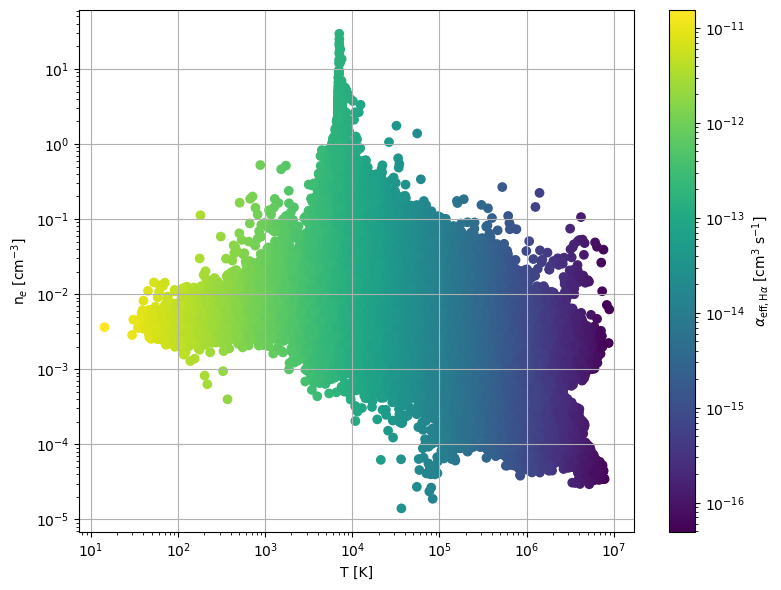

In [8]:
output_dir_exp_history = '/export/home/extragal/francesco.chititegli/TIGRESS_1/History_SPExpanded/'

lol = []
ne_array = []
te_array = [] 

for snapshot_number in snapshot_indexes_to_export:
    #print('Snapshot number ' + str(snapshot_number) + ' at time ' + str(s.nums[snapshot_number]) + ' Myr')
    ds = s.load_vtk(num=s.nums[snapshot_number])
    electron_density = ds.get_field('ne')
    temperature = ds.get_field('T')
    ne_fld = (electron_density['ne'].data.transpose(2, 1, 0)[:,:,min_height:max_height]).reshape(256, 256, tot_height_cells)
    te_fld = (temperature['T'].data.transpose(2, 1, 0)[:,:,min_height:max_height]).reshape(256, 256, tot_height_cells) / 1e4
    ne_array.append(np.mean(ne_fld[125:150,125:150], axis=(0,1)))
    te_array.append(np.mean(te_fld[125:150,125:150], axis=(0,1)) * 1e4)
    raw = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (te_fld**(-0.942-0.030*np.log(te_fld))) * ((ne_fld)**2  * number_density_cf * volume)
    alpha = 1.17e-13 * (te_fld**(-0.942-0.030*np.log(te_fld)))
    raw_2 = raw / (4. * 4. * 1e-6)
    image_Ha = np.sum(raw_2, axis=-1).transpose()
    #image_Ha = image_Ha * (units.cm**-2).to(units.kpc**-2)
    #image_Ha = image_Ha / (1024 * 1024 / 10**14)

    D = 10 * units.Mpc
    D_cm = D.to(units.cm).value
    kpc_per_arcsec = (D.to(units.kpc) * (1 * units.arcsec).to(units.radian)).value
    area_kpc2_per_arcsec2 = kpc_per_arcsec**2
    image_Ha_L_arcsec2 = image_Ha / (4 * np.pi * D_cm**2) * area_kpc2_per_arcsec2

    #print('Finished expanding fields in the snapshot number ' + str(snapshot_number))
    #print(np.nanmedian(np.ndarray.flatten(image_Ha)))
    print(np.nanmean(np.ndarray.flatten(image_Ha_L_arcsec2)))

    #true_output = output_dir_exp_history + 'Snap' + str(snapshot_number) + '/'

    #hdu = fits.PrimaryHDU(image_Ha)
    #hdu.header['BUNIT'] = 'erg s-1 cm-2 sr-1'
    #name_comment = 'Extintionless Ha, Snap ' + str(snapshot_number)
    #hdu.header['COMMENT'] = name_comment
    #hdu.writeto(f"{true_output}Ha_NoDust_TIG_exp.fits", overwrite=True)

    #print('Finished saving arrays for snapshot number ' + str(snapshot_number) + ' in ' + str(true_output))
lol = np.array(lol)
ne_array = np.array(ne_array)
te_array = np.array(te_array)
height_array = np.linspace(-1536, 1536, tot_height_cells)

plt.figure(figsize=(8, 6))
scatter = plt.scatter((te_fld * 1e4).flatten()[::100], ne_fld.flatten()[::100], c=alpha.flatten()[::100], cmap='viridis', norm=LogNorm())
cbar = plt.colorbar(scatter)
cbar.set_label(r'$\alpha_{\mathrm{eff,H}\alpha}$ [cm$^{3}$ s$^{-1}$]')
plt.ylabel(r'n$_{e}$ [cm$^{-3}$]')
plt.xlabel(r'T [K]')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
from scipy.interpolate import interp1d
T_vals = np.array([5000, 7500, 10000, 15000, 20000])
alpha_vals = np.array([2.59e-13, 1.56e-13, 1.17e-13, 8.28e-14, 6.18e-14])
alpha_interp_func = interp1d(T_vals, alpha_vals, kind='linear', fill_value="extrapolate")

for snapshot_number in snapshot_indexes_to_export:
    ds = s.load_vtk(num=s.nums[snapshot_number])
    electron_density = ds.get_field('ne')
    temperature = ds.get_field('T')
    ne_fld = (electron_density['ne'].data.transpose(2, 1, 0)[:,:,min_height:max_height]).reshape(256, 256, tot_height_cells)
    te_fld = (temperature['T'].data.transpose(2, 1, 0)[:,:,min_height:max_height]).reshape(256, 256, tot_height_cells)
    ne_flat = ne_fld.ravel()
    te_flat = te_fld.ravel()
    te_clamped = np.clip(te_flat, 5000, 20000)
    alpha_eff_Ha = np.array(alpha_interp_func(te_clamped))
    new = h_alpha_energy * (1 / (4*np.pi)) * alpha_eff_Ha * ((ne_flat)**2  * number_density_cf * volume)
    new = new.reshape(256, 256, tot_height_cells) / (4. * 4. * 1e-6)
    image_Ha = np.sum(new, axis=-1).transpose()
    D = 9 * units.Mpc
    D_cm = D.to(units.cm).value
    kpc_per_arcsec = (D.to(units.kpc) * (1 * units.arcsec).to(units.radian)).value
    area_kpc2_per_arcsec2 = kpc_per_arcsec**2
    image_Ha_L_arcsec2 = image_Ha / (4 * np.pi * D_cm**2) * area_kpc2_per_arcsec2
    
    print(np.nanmean(np.ndarray.flatten(image_Ha_L_arcsec2)))

4.096425839277442e-18
8.735854202919624e-18
7.922574178241726e-18
8.310805410896668e-18
3.3707737018219633e-18
6.279973571783031e-18
1.999278661015186e-18
5.489997549652632e-18
3.4295157983431956e-18
1.693835729691361e-17


In [21]:
output_dir_exp_history = '/export/home/extragal/francesco.chititegli/TIGRESS_1/History_SPExpanded/'

for snapshot_number in snapshot_indexes_to_export:
    print('Snapshot number ' + str(snapshot_number) + ' at time ' + str(s.nums[snapshot_number]) + ' Myr')
    ds = s.load_vtk(num=s.nums[snapshot_number])
    nH_numdens = ds.get_field('nH')
    map_numdens = (nH_numdens['nH'].data.transpose(2, 1, 0)[:,:,min_height:max_height]).reshape(256, 256, tot_height_cells)
    image_numdens = np.sum(map_numdens, axis=-1).transpose() * 4.0 * (units.pc).to(units.cm)
    print('Finished expanding fields in the snapshot number ' + str(snapshot_number))

    true_output = output_dir_exp_history + 'Snap' + str(snapshot_number) + '/'

    hdu = fits.PrimaryHDU(image_numdens)
    hdu.header['BUNIT'] = 'cm-3'
    name_comment = 'Total Hydrogen Number Density, Snap ' + str(snapshot_number)
    hdu.header['COMMENT'] = name_comment
    hdu.writeto(f"{true_output}nH_surf_exp.fits", overwrite=True)

    print('Finished saving arrays for snapshot number ' + str(snapshot_number) + ' in ' + str(true_output))


Snapshot number 6 at time 260 Myr
Finished expanding fields in the snapshot number 6
Finished saving arrays for snapshot number 6 in /export/home/extragal/francesco.chititegli/TIGRESS_1/History_SPExpanded/Snap6/
Snapshot number 7 at time 270 Myr
Finished expanding fields in the snapshot number 7
Finished saving arrays for snapshot number 7 in /export/home/extragal/francesco.chititegli/TIGRESS_1/History_SPExpanded/Snap7/
Snapshot number 8 at time 280 Myr
Finished expanding fields in the snapshot number 8
Finished saving arrays for snapshot number 8 in /export/home/extragal/francesco.chititegli/TIGRESS_1/History_SPExpanded/Snap8/
Snapshot number 9 at time 290 Myr
Finished expanding fields in the snapshot number 9
Finished saving arrays for snapshot number 9 in /export/home/extragal/francesco.chititegli/TIGRESS_1/History_SPExpanded/Snap9/
Snapshot number 10 at time 300 Myr
Finished expanding fields in the snapshot number 10
Finished saving arrays for snapshot number 10 in /export/home/ext

In [6]:
### In this code, I am still using the RIDOTTO slab, and SHEAR PERIODIC EXPANSION (SPExpansion)
# (-256 < x3 < 256 /// 704 < Nx[3] < 832) YES

# In the list snapshots_fields, every first entry corresponds to the snapshot number, starting from "beginning"
# Then, inside there is a list with the following entries: (0) electron density, (1) temperature, (2) gas_density, (3) HI_num_density

# In the list snaphsots_stars, every first entry corresponds to the snapshot number, starting from "beginning"
# Then, inside there is an array with the stars in each snapshot

snapshots_fields = []
snaphsots_stars = []

for snapshot_number in snapshot_indexes_to_export:
    print('Snapshot number ' + str(snapshot_number) + ' at time ' + str(s.nums[snapshot_number]) + ' Myr')
    ds = s.load_vtk(num=s.nums[snapshot_number])

    # The fields
    electron_density = ds.get_field('ne')
    temperature = ds.get_field('T')
    gas_density = ds.get_field('rho')
    HI_num_density = ds.get_field('nHI')
    # And then SPExpand
    electron_density_exp = expand_xy(s,electron_density)
    temperature_exp = expand_xy(s,temperature)
    gas_density_exp = expand_xy(s,gas_density)
    HI_num_density_exp = expand_xy(s,HI_num_density)
    print('Finished expanding fields in the snapshot number ' + str(snapshot_number))

    # The stars
    sp = s.load_starpar_vtk(num=s.nums_starpar[snapshot_number])
    positions_stars_unmasked = np.array(sp[['x1', 'x2', 'x3']])
    velocities_stars_unmasked = np.array(sp[['v1', 'v2', 'v3']])
    mass_stars_unmasked = np.array(sp['mass'])
    age_stars_unmasked = np.array(sp['age'])
    smoothing_length_stars_unmasked = np.full_like(mass_stars_unmasked, 0.5)
    metallicities_umasked = np.full_like(mass_stars_unmasked, solar_metallicity)
    stars_mask = (mass_stars_unmasked > 0) & (age_stars_unmasked > 0)
    positions_stars = positions_stars_unmasked[stars_mask]
    velocities_stars = velocities_stars_unmasked[stars_mask]
    mass_stars = mass_stars_unmasked[stars_mask]
    age_stars = age_stars_unmasked[stars_mask]
    smoothing_length_stars = smoothing_length_stars_unmasked[stars_mask]
    metallicities = metallicities_umasked[stars_mask]
    # And then SPExpand
    positions_stars_exp_unmasked = []
    velocities_stars_exp_unmasked = []
    mass_stars_exp_unmasked = []
    age_stars_exp_unmasked_unmasked = []
    smoothing_length_stars_exp_unmasked = []
    metallicities_exp_unmasked = []
    for dx_shift in [-3*L_w[0], -2*L_w[0], -L_w[0], 0., L_w[0], 2*L_w[0], 3*L_w[0]]:
        for dy_shift in [-3*L_w[0], -2*L_w[1], -L_w[1], 0., L_w[1], 2*L_w[1], 3*L_w[1]]:
            shifted_pos = positions_stars.copy()
            if (dx_shift==-L_w[0]):
                shear_shift_y = -qOmLt / dx[0]
            elif (dx_shift==L_w[0]):
                shear_shift_y = +qOmLt / dx[0]
            else:
                shear_shift_y = 0.
            shifted_pos = positions_stars.copy()
            shifted_pos[:, 0] += (dx_shift)
            shifted_pos[:, 1] += (dy_shift + shear_shift_y)
            positions_stars_exp_unmasked.append(shifted_pos)
            velocities_stars_exp_unmasked.append(velocities_stars)
            mass_stars_exp_unmasked.append(mass_stars)
            age_stars_exp_unmasked_unmasked.append(age_stars)
            smoothing_length_stars_exp_unmasked.append(smoothing_length_stars)
            metallicities_exp_unmasked.append(metallicities)
    positions_stars_exp_unmasked = np.array(np.vstack(positions_stars_exp_unmasked))
    velocities_stars_exp_unmasked = np.array(np.vstack(velocities_stars_exp_unmasked))
    mass_stars_exp_unmasked = np.array(np.hstack(mass_stars_exp_unmasked))
    age_stars_exp_unmasked = np.array(np.hstack(age_stars_exp_unmasked_unmasked))
    smoothing_length_stars_exp_unmasked = np.array(np.hstack(smoothing_length_stars_exp_unmasked))
    metallicities_exp_unmasked = np.array(np.hstack(metallicities_exp_unmasked))
    
    mask_inside_box = (
    (positions_stars_exp_unmasked[:, 0] >= -1536) & (positions_stars_exp_unmasked[:, 0] <= 1536) &
    (positions_stars_exp_unmasked[:, 1] >= -1536) & (positions_stars_exp_unmasked[:, 1] <= 1536))
    positions_stars_exp = positions_stars_exp_unmasked[mask_inside_box]
    velocities_stars_exp = velocities_stars_exp_unmasked[mask_inside_box]
    mass_stars_exp = mass_stars_exp_unmasked[mask_inside_box]
    age_stars_exp = age_stars_exp_unmasked[mask_inside_box]
    smoothing_length_stars_exp = smoothing_length_stars_exp_unmasked[mask_inside_box]
    metallicities_exp = metallicities_exp_unmasked[mask_inside_box]
    print('Initial star number: ' + str(positions_stars.shape[0]) + '; expected after expansion: ' + str(positions_stars.shape[0] * 9))
    print('Pre-mask extended star number: ' + str(positions_stars_exp_unmasked.shape[0]))
    print('Masked extended star number: ' + str(positions_stars_exp.shape[0]))
    #Putting the stars in an array
    counter = 0
    for i in np.arange(positions_stars_exp.shape[0]):
        if (704 * 4 - 3072 <= positions_stars_exp[i,2]):
            if (positions_stars_exp[i,2] < 832 * 4 - 3072):
                counter = counter + 1
    print(str(counter) + ' stars in the slab VS total of ' + str(positions_stars_exp.shape[0]))
    stars_array_exp = []
    for i in np.arange(positions_stars_exp.shape[0]):
        if (704 * 4 - 3072 <= positions_stars_exp[i,2]):
            if (positions_stars_exp[i,2] < 832 * 4 - 3072):
                position_x = positions_stars_exp[i,0]
                position_y = positions_stars_exp[i,1]
                position_z = positions_stars_exp[i,2]
                smoothing_length = smoothing_length_stars_exp[i]
                mass = mass_stars_exp[i] * mass_cf * 1.5
                metal = metallicities_exp[i]
                age = age_stars_exp[i] * time_cf
                stars_array_exp.append([position_x, position_y, position_z, smoothing_length, mass, metal, age])
    stars_array_exp = np.array(stars_array_exp)
    
    # Putting everything inside the array for SFH snapshots
    snapshots_fields.append([electron_density_exp, temperature_exp, gas_density_exp, HI_num_density_exp])
    snaphsots_stars.append(stars_array_exp)
    print('Finished exporting snapshot number ' + str(snapshot_number))
    print()


Snapshot number 6 at time 260 Myr
Initial star number: 185; expected after expansion: 1665
Pre-mask extended star number: 9065
Masked extended star number: 1665
1656 stars in the slab VS total of 1665
Finished exporting snapshot number 6

Snapshot number 7 at time 270 Myr
Initial star number: 200; expected after expansion: 1800
Pre-mask extended star number: 9800
Masked extended star number: 1800
1791 stars in the slab VS total of 1800
Finished exporting snapshot number 7

Snapshot number 8 at time 280 Myr
Initial star number: 213; expected after expansion: 1917
Pre-mask extended star number: 10437
Masked extended star number: 1917
1908 stars in the slab VS total of 1917
Finished exporting snapshot number 8

Snapshot number 9 at time 290 Myr
Initial star number: 234; expected after expansion: 2106
Pre-mask extended star number: 11466
Masked extended star number: 2106
2097 stars in the slab VS total of 2106
Finished exporting snapshot number 9

Snapshot number 10 at time 300 Myr
Initial

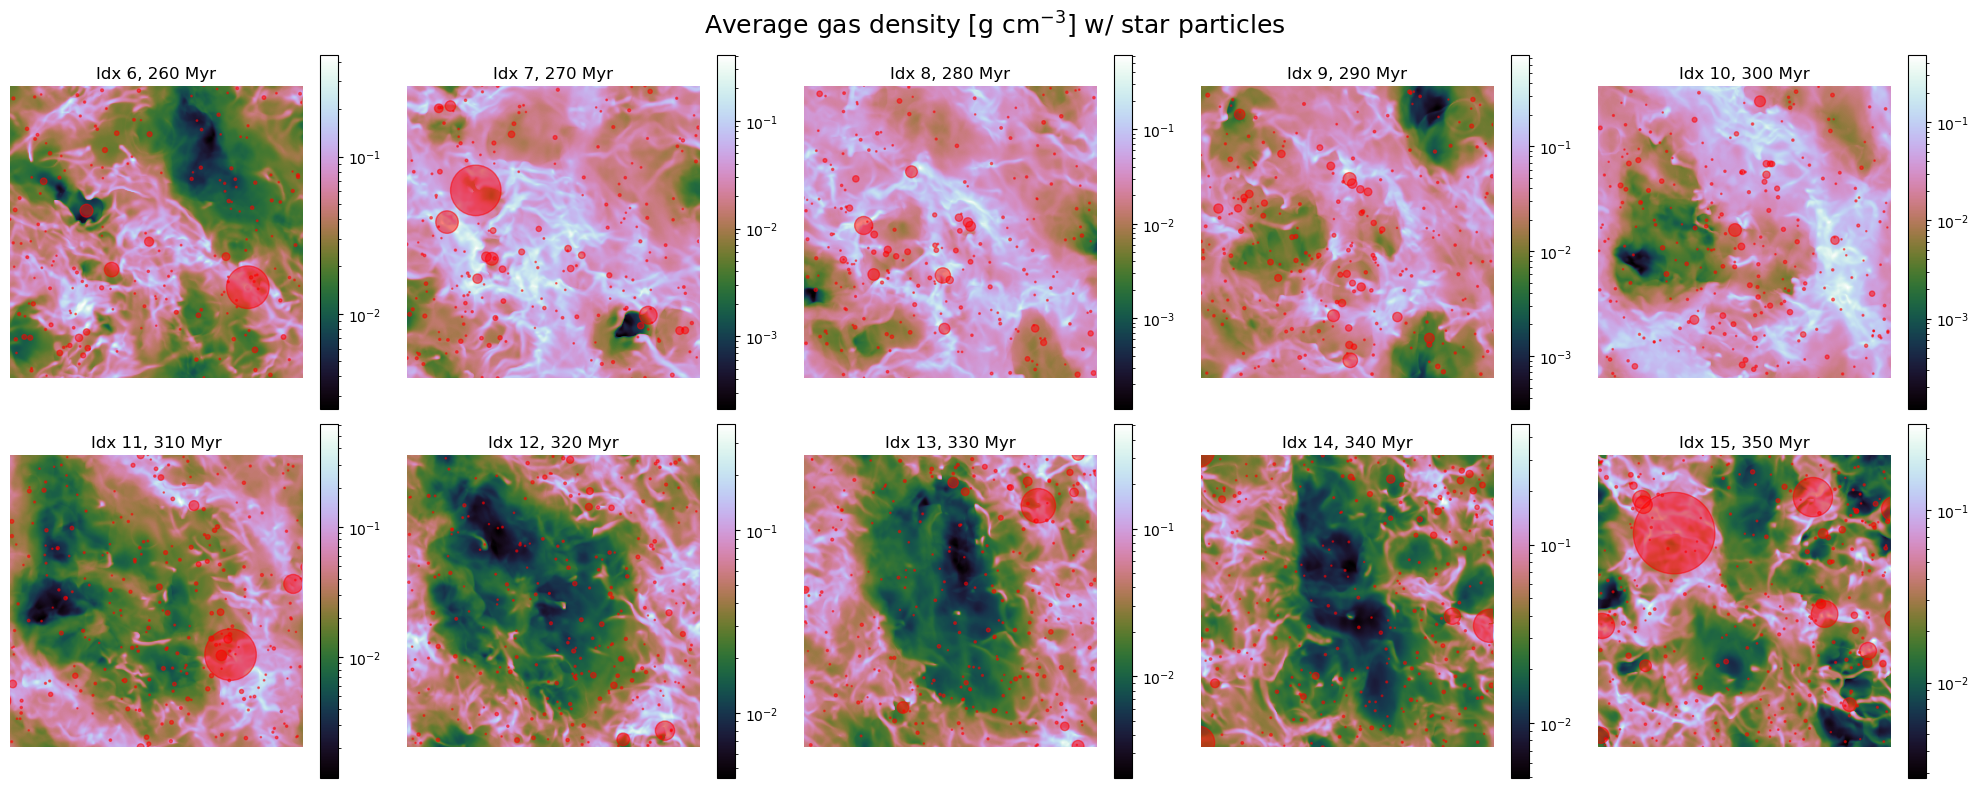

In [118]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8), dpi=100)
axes = axes.flatten()

for i, ax in enumerate(axes):
    plot_data = np.mean((snapshots_fields[i][3]['rho'].data).transpose(2, 1, 0), axis=-1).transpose()
    
    im = ax.imshow(plot_data, cmap='cubehelix', origin='lower', norm=LogNorm(vmin=plot_data.min(), vmax=plot_data.max()))
    ax.scatter(snaphsots_stars[i][:,0]/4. + 384., snaphsots_stars[i][:,1]/4. + 384., s=(snaphsots_stars[i][:,6] * 5e3 * time_cf)**(-1), c='red', alpha=0.5)
    plt.colorbar(im, ax=ax)
    ax.set_xlim(256,512)
    ax.set_ylim(256,512)
    ax.set_title('Idx ' + str(snapshot_indexes_to_export[i]) + ', ' + str(snapshots_times_to_export[i]) + ' Myr')
    ax.axis('off')

fig.suptitle("Average gas density [g cm$^{-3}$] w/ star particles", fontsize=18)
#fig.savefig(f"{tigress_dir}Snapshot_evolution.png", dpi=100)
plt.tight_layout()
plt.show()


# Putting everything in arrays and then saving them

In [10]:
# I computed the 21cm luminosity with a first-order approximation by employing the formula (8.3)
# by Bruce Draine (2011), page 71.
print('The pre-factor is: ' + str((3/4) * 2.8843e-15 * 6.62e-27 * 3.0e8 / 21e-2))

def mean_density_star_disk(xmin, ymin, zmin, xmax, ymax, zmax):
    sigma_star=42
    z_star=245

    def rho_z(z):
        return (sigma_star / 2) * (z_star**2) / ( (z**2 + z_star**2)**(3/2) )
        
    integral_rho, _ = quad(rho_z, zmin, zmax)
    mean_density = (integral_rho * dx[0] * dx[1]) / volume

    # the result is in Msun/pc**3
    return mean_density

The pre-factor is: 2.0457927857142857e-32


In [13]:
# Snapshot fields has [0] electron number density, [1] temperature, [2] gas density, [3] HI fraction

for indx, snapshot_number in enumerate(snapshot_indexes_to_export):

    print('NEW SNAPSHOT! Processing snapshot number ' + str(snapshot_number) + ', with relative index ' + str(indx))
    Halfa_array = []
    SED_array = []
    old_disk_array = []
    dust_array = []
    hydrogen_array = []
    ID_number = 0
    
    for i in range(Nx_exp[0]):
        print(i)
        for j in range(Nx_exp[1]):
            for k in range(704, 832):
                xmin_val = xmin_exp[i]
                ymin_val = ymin_exp[j]
                zmin_val = zmin_exp[k]
                xmax_val = xmax_exp[i]
                ymax_val = ymax_exp[j]
                zmax_val = zmax_exp[k]
                
                dust_density_val = (snapshots_fields[indx][2]['rho'].data)[k, j, i].astype(np.float64) * dust_to_gas_ratio
                temperature_val = (snapshots_fields[indx][1]['T'].data)[k, j, i].astype(np.float64)
                HI_ndens_val = (snapshots_fields[indx][3]['nHI'].data)[k, j, i].astype(np.float64)
                metallicities_val = solar_metallicity * 0.03
                
                ne2 = (snapshots_fields[indx][0]['ne'].data)[k, j, i].astype(np.float64)
                T_4 = (snapshots_fields[indx][1]['T'].data)[k, j, i].astype(np.float64) / 1e4
                h_alpha_luminosity_val = h_alpha_energy * (1.17e-13 / (4*np.pi)) * (T_4**(-0.942-0.030*np.log(T_4))) * (ne2**2 * number_density_cf * volume)
                
                hydrogen_density_val = (HI_ndens_val) * H_mass_grams
                H_surf_val = hydrogen_density_val * (units.g).to(units.M_sun) * number_density_cf * 4.0
                HI_prefattore = (3/4) * 2.8843e-15 * 6.62e-27 * 3.0e8 / 21e-2
                HI_lum_val = HI_prefattore * HI_ndens_val * number_density_cf * volume
                
                star_disk_mass_val = mean_density_star_disk(xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val) * volume
                
                Halfa_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, ID_number, dust_density_val])
                SED_array.append([h_alpha_wave, h_alpha_luminosity_val, ID_number])
                dust_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, dust_density_val, temperature_val])          
                hydrogen_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, hydrogen_density_val, metallicities_val, temperature_val, H_surf_val, HI_lum_val])
                old_disk_array.append([xmin_val, ymin_val, zmin_val, xmax_val, ymax_val, zmax_val, star_disk_mass_val, solar_metallicity, 9.99])
                
    Halfa_array = np.array(Halfa_array)
    SED_array = np.array(SED_array)
    dust_array = np.array(dust_array)
    hydrogen_array = np.array(hydrogen_array)
    old_disk_array = np.array(old_disk_array)
                
    print('Total mass analitically computed: ' + str(9 * 1024 * 1024 * 42 * 256 / np.sqrt(256**2 + 245**2)) + ' Msun')
    print('Total mass computed as mean density * volume * number cells: ' + str(np.mean(old_disk_array[:,6]) * 75497472) + ' Msun')
    print('Difference An - Num: ' + str((9 * 1024 * 1024 * 42 * 256 / np.sqrt(256**2 + 245**2)) - (np.mean(old_disk_array[:,6]) * 75497472)) + ' Msun')
    print('Average metallicity: ' + str(np.mean(old_disk_array[:,7])))

    #######################################################################################################################

    true_output = output_dir_exp_history + 'Snap' + str(snapshot_number) + '/'

    #######################################################################################################################

    fmt_Halfa = ["%g", "%g", "%g", "%g", "%g", "%g", "%d", "%g"]
    header = """# Halfa_Ridotto_exp.txt: import file for cell source -- Halfa
    # Column 1: xmin (pc)
    # Column 2: ymin (pc)
    # Column 3: zmin (pc)
    # Column 4: xmax (pc)
    # Column 5: ymax (pc)
    # Column 6: zmax (pc)
    # Column 7: index (1)
    # Column 8: mass density (g/cm3)
    #
    """
    with open(f"{true_output}Halfa_Ridotto_exp.txt", "w") as txt_file:
        txt_file.write(header)
        np.savetxt(txt_file, Halfa_array, fmt=fmt_Halfa)

    #######################################################################################################################
    
    header = """# Dust_Ridotto_exp.txt: import file for cell media -- dust
    # Column 1: xmin (pc)
    # Column 2: ymin (pc)
    # Column 3: zmin (pc)
    # Column 4: xmax (pc)
    # Column 5: ymax (pc)
    # Column 6: zmax (pc)
    # Column 7: mass density (g/cm3)
    # Column 8: temperature (K)
    #
    """
    with open(f"{true_output}Dust_Ridotto_exp.txt", "w") as txt_file:
        txt_file.write(header)
        np.savetxt(txt_file, dust_array, fmt="%g")
    
    ########################################################################################################################

    header = """# Hydrogen_21_Ridotto_ConEmissione_exp.txt: import file for cell media -- gas
    # Column 1: xmin (pc)
    # Column 2: ymin (pc)
    # Column 3: zmin (pc)
    # Column 4: xmax (pc)
    # Column 5: ymax (pc)
    # Column 6: zmax (pc)
    # Column 7: mass density (g/cm3)
    # Column 8: metallicity (1)
    # Column 9: temperature (K)
    # Column 10: surface mass density (Msun/pc2)
    # Column 11: HI luminosity (MJy/sr)
    #
    """
    with open(f"{true_output}Hydrogen_21_Ridotto_ConEmissione_exp.txt", "w") as txt_file:
        txt_file.write(header)
        np.savetxt(txt_file, hydrogen_array, fmt="%g")
        
    ########################################################################################################################
    
    header = """# Old_Stars_Ridotto_exp.txt: import file for cell source 
    # Column 1: xmin (pc)
    # Column 2: ymin (pc)
    # Column 3: zmin (pc)
    # Column 4: xmax (pc)
    # Column 5: ymax (pc)
    # Column 6: zmax (pc)
    # Column 7: mass (Msun)
    # Column 8: metallicity (1)
    # Column 9: age (Gyr)
    #
    """

    with open(f"{true_output}Old_Stars_Ridotto_exp.txt", "w") as txt_file:
        txt_file.write(header)
        np.savetxt(txt_file, old_disk_array, fmt="%g")
    
    ########################################################################################################################

    header = """# Stars_Ridotto_exp.txt: import file for particle source 
    # Column 1: position x (pc)
    # Column 2: position y (pc)
    # Column 3: position z (pc)
    # Column 4: smoothing length (pc)
    # Column 5: mass (Msun)
    # Column 6: metallicity (1)
    # Column 7: age (Gyr)
    #
    """
    with open(f"{true_output}Stars_Ridotto_exp.txt", "w") as txt_file:
        txt_file.write(header)
        np.savetxt(txt_file, snaphsots_stars[indx], fmt="%g")

    print('Finished saving ' + str(len(snaphsots_stars[indx])) + ' stars')
    print('Finished saving arrays for snapshot number ' + str(snapshot_number))

    ########################################################################################################################

    from pts.storedtable.io import writeStoredTable
    from pts.storedtable.io import readStoredTable

    def convertMonochromaticSimulation(wavelengths, luminosities, indexes, outFilePath):
        erg_to_watt = 1e-7
        luminosities_per_micron = luminosities * erg_to_watt
        w = np.array([0.656, 0.657])

        ID = indexes
        L = np.zeros((len(w), len(luminosities)))
        L[0, :] = luminosities * 1e3
        L[1, :] = luminosities * 1e3

        writeStoredTable(outFilePath,['lambda', 'index'], ['m', '1'], ['lin', 'lin'],[w*1e-6, ID],['Llambda'], ['W/m'], ['lin'], [L*1e6])
    convertMonochromaticSimulation(SED_array[:,0], SED_array[:,1], SED_array[:,2].astype(int), f"{true_output}SEDfamily_Ridotto_exp.stab")
    readStoredTable(f"{true_output}SEDfamily_Ridotto_exp.stab")

    ########################################################################################################################

    print('Finished snapshot number ' + str(snapshot_number) + ', with relative index ' + str(indx))
    print()


Finished saving 1656 stars
Finished saving arrays for snapshot number 6
Finished snapshot number 6, with relative index 0

Finished saving 1791 stars
Finished saving arrays for snapshot number 7
Finished snapshot number 7, with relative index 1

Finished saving 1908 stars
Finished saving arrays for snapshot number 8
Finished snapshot number 8, with relative index 2

Finished saving 2097 stars
Finished saving arrays for snapshot number 9
Finished snapshot number 9, with relative index 3

Finished saving 2169 stars
Finished saving arrays for snapshot number 10
Finished snapshot number 10, with relative index 4

Finished saving 2232 stars
Finished saving arrays for snapshot number 11
Finished snapshot number 11, with relative index 5

Finished saving 2277 stars
Finished saving arrays for snapshot number 12
Finished snapshot number 12, with relative index 6

Finished saving 2358 stars
Finished saving arrays for snapshot number 13
Finished snapshot number 13, with relative index 7

Finished